In [2]:
from src import *
from src.supcon import *

import seaborn as sns
import timm
from torch.utils.data import DataLoader

In [3]:
CFG.epochs = 50
CFG.samples_per_class = 400

In [4]:
# train_data = pd.read_csv(os.path.join(DATA_FOLDER, 'trainLabels.csv'))
train_data = pd.read_csv(os.path.join(DATA_FOLDER, 'trainLabels_cropped.csv'))
train_data

,Unnamed: 0.1,Unnamed: 0,image,level
0,0,0,10_left,0
1,1,1,10_right,0
2,2,2,13_left,0
3,3,3,13_right,0
4,4,4,15_left,1
...,...,...,...,...
35103,35104,35121,44347_right,0
35104,35105,35122,44348_left,0
35105,35106,35123,44348_right,0
35106,35107,35124,44349_left,0


In [5]:
# remove all images from the csv if they are not in the folder
lst = map(lambda x: x[:-5], os.listdir(TRAIN_DATA_FOLDER))
train_data = train_data[train_data.image.isin(lst)].reset_index(drop=True)
train_data = train_data.groupby('level').head(CFG.samples_per_class).reset_index(drop=True)
len(train_data)

2000

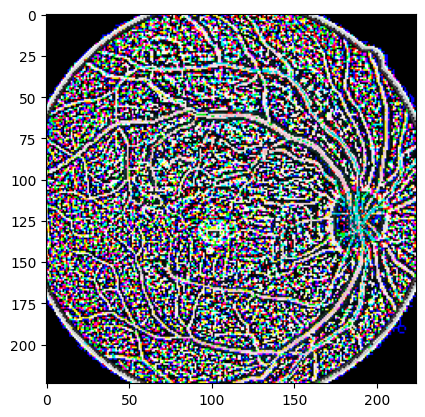

In [6]:
# visualize the transformations
train_dataset = ImageTrainDataset(TRAIN_DATA_FOLDER, train_data, val_transforms)
image, label = train_dataset[15]
transformed_img_pil = func.to_pil_image(image)
plt.imshow(transformed_img_pil)

##### Note that the severity levels in test / query images are 0, 1, 2, 3 ie only 4 levels.
##### However the severity levels in train images are 0, 1, 2, 3, 4 ie 5 levels.

In [7]:
os.listdir(TEST_DATA_FOLDER )

['DR2', 'Normal', 'DR3', 'DR1']

In [8]:
# load model
model = SupConModel(timm.create_model(CFG.model_name, pretrained=True, num_classes=0))
model.load_state_dict(torch.load(OUTPUT_FOLDER + 'ckpt_epoch_8.pth'))
dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=CFG.workers)
model.eval()
model = model.to(device)

In [9]:
def convert_level(level):
    """
    converts training level to  query level
    """
    if level == 0:
        return 0
    else:
        return level * 3 / 4

## Retrieving Nearest Neighbours and Selecting Label Accordingly

In [10]:
import faiss
from tqdm import tqdm


# make vector store
res = faiss.StandardGpuResources()
config = faiss.GpuIndexFlatConfig()
config.device = 1 
dimension = 128  # Dimension of the vectors

index = faiss.GpuIndexFlatL2(res, dimension, config)
k = 5

In [11]:
# get all embeddings and store them in the vector store
model.eval()
embeddings = []
with torch.no_grad():
    for image, _ in tqdm(dataloader, desc="Generating embeddings and indexing"):
        image = image.to(device)
        output = model(image)
        embedding = output.cpu().numpy().astype('float32')
        index.add(embedding)

Generating embeddings and indexing: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [07:16<00:00,  4.58it/s]


In [12]:
def get_nearest_images(query_img, k=k):
    # query image embeddings
    query_image = val_transforms(query_img).unsqueeze(0).to(device)
    query_embedding = model(query_image).detach().cpu().numpy().astype('float32')

    # search
    distances, indices = index.search(query_embedding, k)

    # flatten
    indices = indices.flatten()
    distances = distances.flatten()

    print(f"Indices of {k} nearest images:", indices)
    print("Levels of nearest images [0 - 4]:", [train_data.loc[idx].level for idx in indices])
    print("Levels in query form [0 - 3]:", [convert_level(train_data.loc[idx].level) for idx in indices])
    print("Distances:", distances)
    print("Mean distance:", np.mean(distances))
    print("Median distance:", np.median(distances))

    print("----------------------------------------")
    print(f"Predicted Level [from 0 to 3]: {np.mean([convert_level(train_data.loc[idx].level) for idx in indices]): .1f}")
    
    return indices

In [15]:
# taking a random image from the DR 2 class
query_img = Image.open(TEST_DATA_FOLDER + '/DR2/1ffa93c6-8d87-11e8-9daf-6045cb817f5b..JPG')
indices = get_nearest_images(query_img)

Indices of 5 nearest images: [1764  396 1616  618 1790]
Levels of nearest images [0 - 4]: [3, 2, 4, 2, 4]
Levels in query form [0 - 3]: [2.25, 1.5, 3.0, 1.5, 3.0]
Distances: [0.0012784  0.00225961 0.0031547  0.00316548 0.00338447]
Mean distance: 0.0026485324
Median distance: 0.003154695
----------------------------------------
Predicted Level [from 0 to 3]:  2.2


Text(0.5, 0.98, 'Predicted Level: 2.2 - using SupCLR')

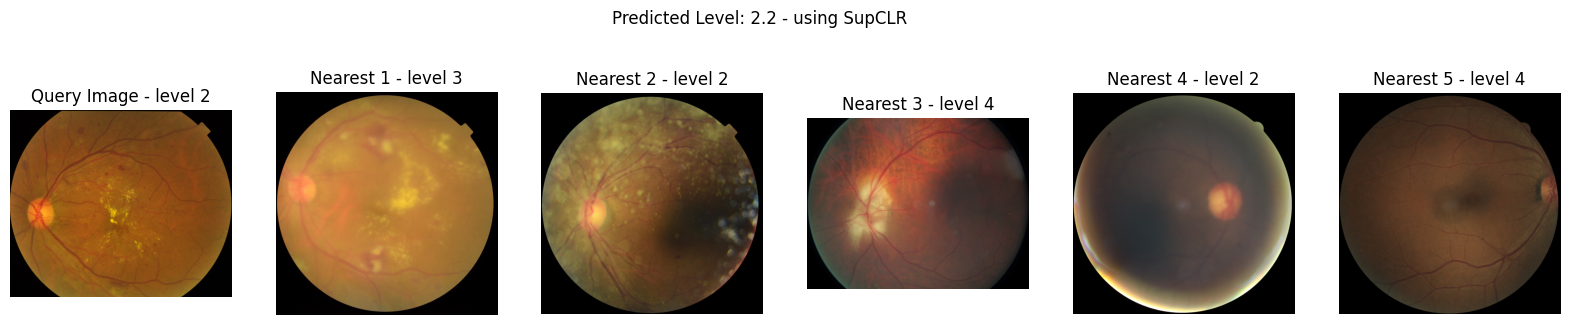

In [17]:
# show the nearest images
fig, axs = plt.subplots(1, k+1, figsize=(20, 4))

# query image
axs[0].imshow(query_img)
axs[0].axis('off')
axs[0].set_title("Query Image - level 2")

for i, idx in enumerate(indices):
    img = Image.open(TRAIN_DATA_FOLDER + train_data.loc[idx].image + ".jpeg")
    axs[i+1].imshow(img)
    axs[i+1].axis('off')
    axs[i+1].set_title(f"Nearest {i+1} - level {train_data.loc[idx].level}")
    
plt.suptitle('Predicted Level: 2.2 - using SupCLR')

## Disease Severity Order on a Continuous Spectrum

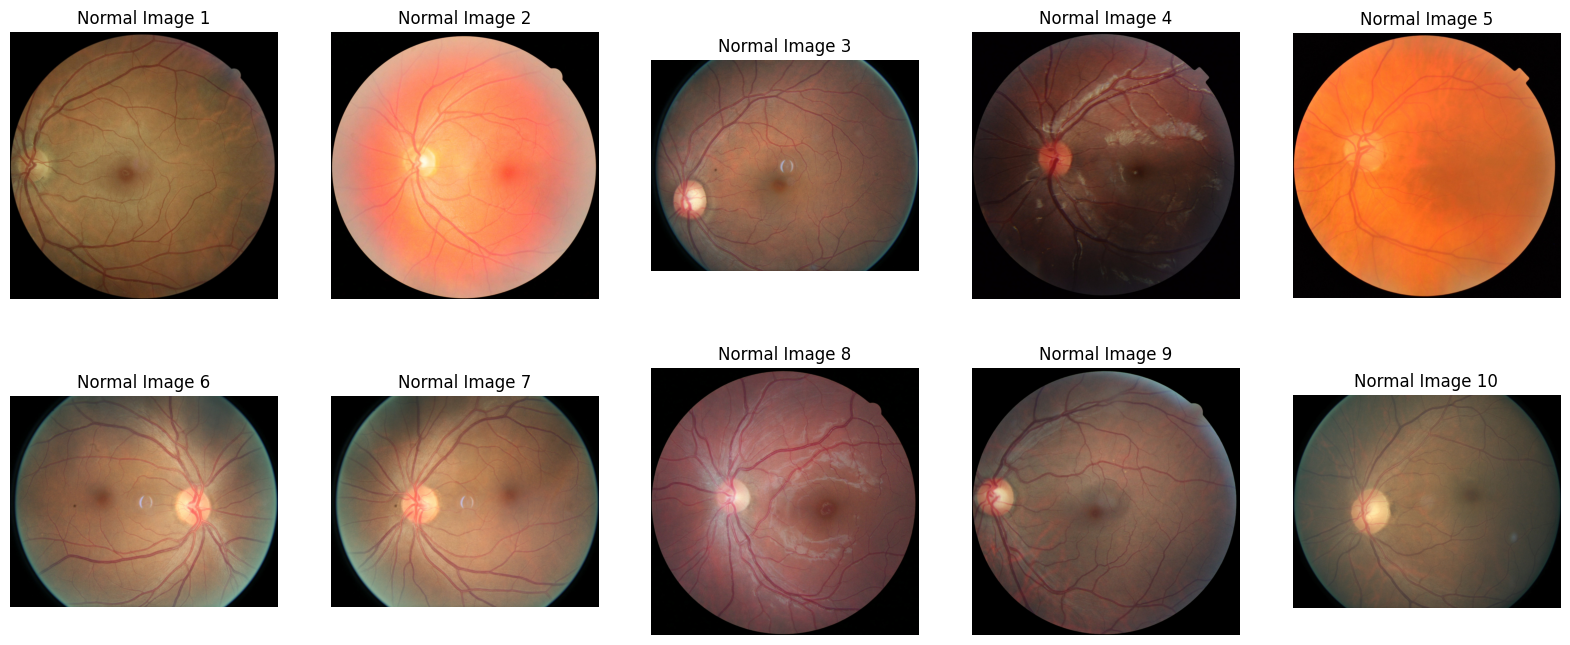

In [18]:
# randomly sample 10 images from the train data folder

normal_images = list(train_data[train_data.level == 0].sample(10).image)
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

axs = axs.ravel()

for i, img_name in enumerate(normal_images):
    img = Image.open(TRAIN_DATA_FOLDER + img_name + ".jpeg")
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title(f"Normal Image {i+1}")

In [19]:
def get_embeddings(img, model):
    img = val_transforms(img).unsqueeze(0).to(device)
    output = model(img)
    return output

def get_severity_order(query_img, model, base_images):
    # median euclidean distance of the query image from the base images
    
    # Get embeddings for the query image and base images in a single batch
    query_embedding = get_embeddings(query_img, model)
    base_embeddings = torch.cat([get_embeddings(Image.open(TRAIN_DATA_FOLDER + img_name + ".jpeg"), model)
                                   for img_name in base_images])

    # Calculate pairwise distances using vectorized operations
    distances = torch.norm(query_embedding - base_embeddings, dim=1)

    # Get the median distance
    severity = torch.median(distances).item()

    return severity

In [20]:
severity = get_severity_order(query_img, model, normal_images)
print(f'Order of severity of the disease: {severity:.2f}')

Order of severity of the disease: 0.45


#### Note that this severity order is totally different from the levels we had in the dataset.

In [21]:
# finding severity for all test images
severities = {'0': [], '1': [], '2': [], '3': []}

rel = {'0': 'Normal/', '1': 'DR1/', '2': 'DR2/', '3': 'DR3/'}

for level in rel:
    for img_name in os.listdir(TEST_DATA_FOLDER + rel[level]):
        img = Image.open(TEST_DATA_FOLDER + rel[level] + img_name)
        severity = get_severity_order(img, model, normal_images)
        severities[level].append(severity)

Text(0.5, 1.0, 'Severity Order vs Level')

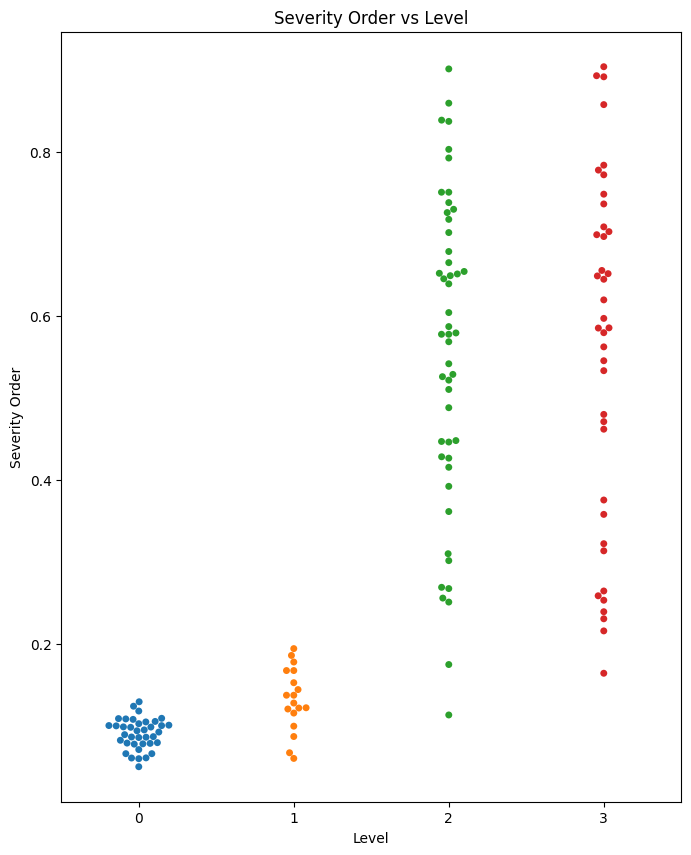

In [22]:
# make a box plot for level vs predicted severity order
fig = plt.figure(figsize=(8, 10))
sns.swarmplot(data=[severities['0'], severities['1'], severities['2'], severities['3']])
plt.xlabel('Level')
plt.ylabel('Severity Order')
plt.title('Severity Order vs Level')

In [23]:
plt.savefig(OUTPUT_FOLDER + 'severity_order_sup_con.png', dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>